# Stellargraph Ensemble example

Using an ensemble of GraphSAGE models for node attribute inference on the CORA citation network.

Import NetworkX and stellar:

In [54]:
import networkx as nx
import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from stellargraph import Ensemble

from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
def plot_history(history):
    plt.figure(figsize=(12, 10))
    
    for h in history:    
        metrics = sorted(h.history.keys())
        metrics = metrics[:len(metrics)//2]
        for i, m in enumerate(metrics):
            # summarize history for metric m
            plt.subplot(len(metrics), 1, i+1)
            c_train = 'b'
            c_test = 'g'

            plt.plot(h.history[m], c=c_train)
            plt.plot(h.history['val_' + m], c=c_test)
            if i <= 1 :
                plt.title(m)
                plt.ylabel(m)
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper right')

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = os.path.expanduser("~/data/cora")

In [3]:
def load_cora(data_dir):
    # load the graph from the edge list
    edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
    edgelist["label"] = "cites"
    
    Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
    nx.set_node_attributes(Gnx, "paper", "label")
    
    # Load the features and subjects for the nodes
    feature_names = ["w_{}".format(ii) for ii in range(1433)]
    column_names =  feature_names + ["subject"]
    node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)
    
    return Gnx, node_data, feature_names

In [4]:
Gnx, node_data, feature_names = load_cora(data_dir)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [5]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [6]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=0.1, test_size=None, stratify=node_data['subject'])

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [7]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [8]:
node_features = node_data[feature_names]

## Creating the GraphSAGE model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [9]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [10]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a mapper. The mappers are specialized to the model and the learning task so we choose the `GraphSAGENodeMapper` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [11]:
batch_size = 50; num_samples = [5, 5]

A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [12]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

For training we map only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [13]:
train_gen = generator.flow(train_data.index, train_targets, shuffle=True)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [14]:
graphsage_model = GraphSAGE(
    layer_sizes=[16, 8],
    generator=train_gen,
    bias=True,
    dropout=0.5,
)

Now we create a model to predict the 7 categories using Keras softmax layers. Note that we need to use the `G.get_target_size` method to find the number of categories in the data.

In [15]:
x_inp, x_out = graphsage_model.default_model(flatten_output=True)
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [16]:
prediction.shape

TensorShape([Dimension(None), Dimension(7)])

### Create and Ensemble of models

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [44]:
model = Model(inputs=x_inp, outputs=prediction)

model = Ensemble(model, n_estimators=2, n_predictions=3)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [45]:
model  # The model is of type stellargraph.utils.ensemble.Ensemble but has the same interface as a Keras model

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [46]:
test_gen = generator.flow(test_data.index, test_targets)

In [47]:
history = model.fit_generator(
    train_gen,
    epochs=12,
    validation_data=test_gen,
    verbose=0,
    shuffle=False
)

Epoch 1/12
6/6 [==============================] - 2s 308ms/step - loss: 0.6133 - acc: 0.9424 - val_loss: 0.9312 - val_acc: 0.7584
Epoch 2/12
6/6 [==============================] - 1s 196ms/step - loss: 0.6440 - acc: 0.9363 - val_loss: 0.9207 - val_acc: 0.7535
Epoch 3/12
6/6 [==============================] - 1s 196ms/step - loss: 0.5577 - acc: 0.9253 - val_loss: 0.9066 - val_acc: 0.7580
Epoch 4/12
6/6 [==============================] - 1s 233ms/step - loss: 0.5514 - acc: 0.9517 - val_loss: 0.8950 - val_acc: 0.7596
Epoch 5/12
6/6 [==============================] - 1s 195ms/step - loss: 0.5365 - acc: 0.9305 - val_loss: 0.8725 - val_acc: 0.7756
Epoch 6/12
6/6 [==============================] - 1s 236ms/step - loss: 0.5062 - acc: 0.9483 - val_loss: 0.8764 - val_acc: 0.7625
Epoch 7/12
6/6 [==============================] - 1s 234ms/step - loss: 0.5134 - acc: 0.9135 - val_loss: 0.8571 - val_acc: 0.7691
Epoch 8/12
6/6 [==============================] - 1s 234ms/step - loss: 0.4865 - acc: 0.94

/Users/eli024/anaconda3/envs/link-prediction/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


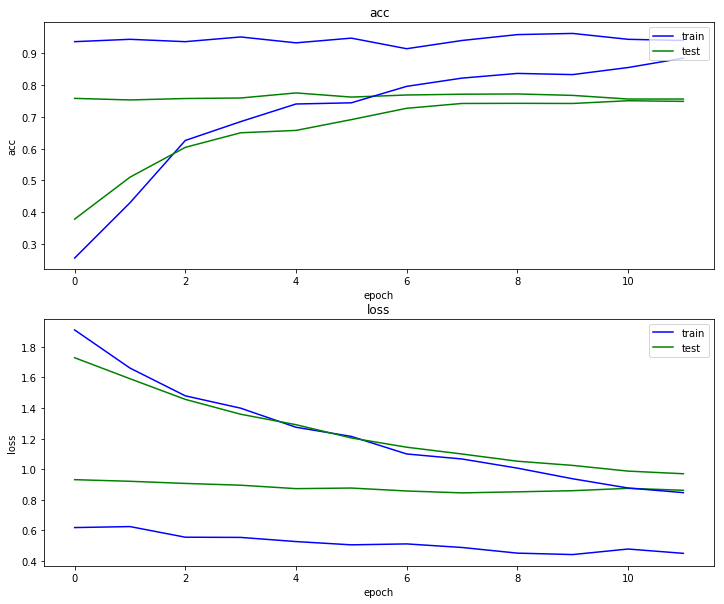

In [49]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [50]:
test_metrics_mean, test_metrics_std = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the trained models:")
for name, m, s in zip(model.metrics_names(), test_metrics_mean, test_metrics_std):
    print("\t{}: {:0.4f}±{:0.4f}".format(name, m, s))


Train Set Metrics of the trained model:
	loss: 0.9145±0.0515
	acc: 0.7564±0.0033


### Making predictions with the model

Now let's get the predictions themselves for all nodes using another mapper:

In [51]:
all_nodes = node_data.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [52]:
type(all_predictions), len(all_predictions), len(all_predictions[0]), len(all_predictions[1])

(list, 2, 3, 3)

In [58]:
all_predictions_arr = np.array(all_predictions)
all_predictions_arr.shape

(2, 3, 2708, 7)

In [75]:
selected_query_point = 0

In [76]:
qp_predictions = all_predictions_arr[:, :, selected_query_point, :]
qp_predictions.shape

(2, 3, 7)

In [77]:
qp_predictions = qp_predictions.reshape(np.product(qp_predictions.shape[0:-1]), qp_predictions.shape[-1])
qp_predictions.shape

(6, 7)

In [91]:
# NOTE: Check that this is doing the right thing
inv_subject_mapper = {k: v for k, v in enumerate(target_encoding.feature_names_)}
inv_subject_mapper

{0: 'subject=Case_Based',
 1: 'subject=Genetic_Algorithms',
 2: 'subject=Neural_Networks',
 3: 'subject=Probabilistic_Methods',
 4: 'subject=Reinforcement_Learning',
 5: 'subject=Rule_Learning',
 6: 'subject=Theory'}

0.9192994


Text(0.5,1,'Denisty plots of predicted probabilities for each subject')

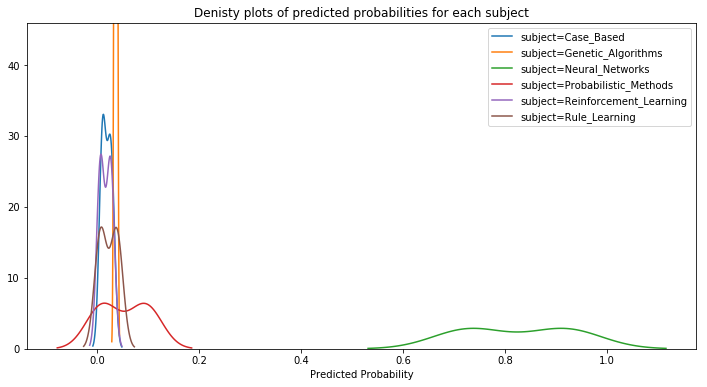

In [92]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,6))
print(np.max(qp_predictions))
plt.ylim(0, 50*np.max(qp_predictions))
for i in range(len(qp_predictions)):
    sns.kdeplot(data=qp_predictions[:, i].reshape((-1,)), label=inv_subject_mapper[i])
plt.xlabel("Predicted Probability")
plt.title("Denisty plots of predicted probabilities for each subject")

Another view of the same predictions

Text(0.5,0,'Subject')

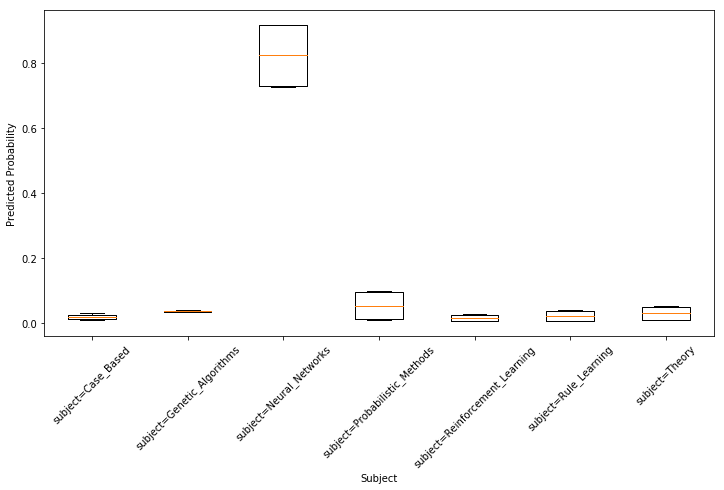

In [94]:
fig, ax = plt.subplots(figsize=(12,6))
ax.boxplot(x=qp_predictions)
ax.set_xticklabels(target_encoding.feature_names_)
ax.tick_params(axis='x', rotation=45)
plt.ylabel("Predicted Probability")
plt.xlabel("Subject")

## Node embeddings
Evaluate node embeddings as activations of the output of graphsage layer stack, and visualise them, coloring nodes by their subject label.

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the `x_out` variable. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [ ]:
emb = embedding_model.predict_generator(all_mapper)
emb.shape

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [ ]:
X = emb
y = np.argmax(target_encoding.transform(node_data[["subject"]].to_dict('records')), axis=1)

In [ ]:
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_data.index)
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_data.index)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

In [ ]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()